In [1]:
import os
import datetime
import math
import random
import string
import itertools

import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.model_selection
import keras_ocr

2024-09-30 07:41:25.765519: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-30 07:41:25.906356: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
data_dir = 'text'

# Пути к файлам данных
wordlist_file = os.path.join(data_dir, 'sah.wordlist')  # Слова на якутском языке
fonts_dir = os.path.join(data_dir, 'fonts')  # Папка с шрифтами

In [3]:
alphabet = 'абвгдеёжзийклмнопрстуфхцчшщъыьэюяҕҥөһү '
recognizer_alphabet = ''.join(sorted(set(alphabet.lower())))

In [6]:
# Загрузка списка слов из файла wordlist_file
with open(wordlist_file, 'r', encoding='utf-8') as f:
    word_list = [line.strip() for line in f if line.strip()]

In [7]:
def get_train_val_test_split(arr):
    train, valtest = sklearn.model_selection.train_test_split(arr, train_size=0.8, random_state=42)
    val, test = sklearn.model_selection.train_test_split(valtest, train_size=0.5, random_state=42)
    return train, val, test
    
# Разделение списка слов
train_words, val_words, test_words = get_train_val_test_split(word_list)

# Разделение шрифтов
train_fonts, val_fonts, test_fonts = get_train_val_test_split(fonts)

In [8]:
def word_text_generator(words):
    while True:
        random.shuffle(words)
        for word in words:
            yield word

# Создание генераторов текста для тренировочного, валидационного и тестового наборов
text_generators = [
    word_text_generator(words) for words in [train_words, val_words, test_words]
]

In [9]:
backgrounds = keras_ocr.data_generation.get_backgrounds(cache_dir=data_dir)

# Разделение фонов на тренировочные, валидационные и тестовые наборы
train_backgrounds, val_backgrounds, test_backgrounds = get_train_val_test_split(backgrounds)

Looking for text/backgrounds.zip


In [10]:
# Создание списка групп шрифтов для каждого набора
font_splits = [train_fonts, val_fonts, test_fonts]
background_splits = [train_backgrounds, val_backgrounds, test_backgrounds]

# Создание генераторов изображений для каждого набора
image_generators = [
    keras_ocr.data_generation.get_image_generator(
        height=640,
        width=640,
        text_generator=text_generator,
        font_groups={
            alphabet: current_fonts
        },
        backgrounds=current_backgrounds,
        font_size=(60, 120),
        margin=50,
        rotationX=(-0.05, 0.05),
        rotationY=(-0.05, 0.05),
        rotationZ=(-15, 15)
    ) for text_generator, current_fonts, current_backgrounds in zip(
        text_generators,
        [train_fonts, val_fonts, test_fonts],
        [train_backgrounds, val_backgrounds, test_backgrounds]
    )
]

Первое сгенерированное валидационное изображение содержит текст: х
ойут


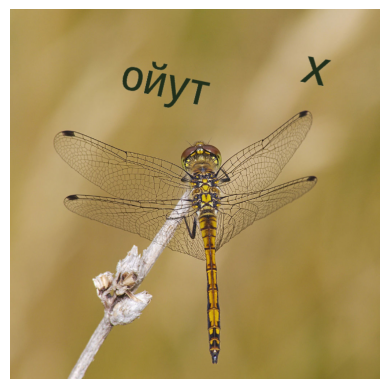

In [11]:
# Посмотрим, как выглядит первое сгенерированное изображение валидационного набора
image, lines = next(image_generators[1])
text = keras_ocr.data_generation.convert_lines_to_paragraph(lines)
print('Первое сгенерированное валидационное изображение содержит текст:', text)
plt.imshow(image)
plt.axis('off')
plt.show()

In [12]:
# Создание детектора
detector = keras_ocr.detection.Detector(weights='clovaai_general')

# Создание распознавателя с нашим алфавитом
recognizer = keras_ocr.recognition.Recognizer(
    alphabet=recognizer_alphabet,
    weights=None  # Обучение с нуля
)
recognizer.compile()

Looking for /root/.keras-ocr/craft_mlt_25k.h5


2024-09-30 07:41:49.715284: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-30 07:41:52.226817: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 19458 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:01:00.0, compute capability: 8.6
2024-09-30 07:41:52.227617: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 16858 MB memory:  -> device: 1, name: NVIDIA RTX A5000, pci bus id: 0000:24:00.0, compute capability: 8.6
2024-09-30 07:41:52.228262: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:2 w

In [26]:
detector_batch_size = 8
detector_basepath = os.path.join(data_dir, f'detector_{datetime.datetime.now().isoformat()}')

# Создание генераторов батчей для детектора
detection_train_generator, detection_val_generator, detection_test_generator = [
    detector.get_batch_generator(
        image_generator=image_generator,
        batch_size=detector_batch_size
    ) for image_generator in image_generators
]

In [40]:
# Рассчитываем количество шагов на эпоху для детектора
train_steps_detector = math.ceil(len(train_backgrounds) / detector_batch_size)
val_steps_detector = math.ceil(len(val_backgrounds) / detector_batch_size)

# Обучение детектора
detector.model.fit(
    detection_train_generator,
    steps_per_epoch=train_steps_detector,
    epochs=1,
    workers=0,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(restore_best_weights=True, patience=5),
        tf.keras.callbacks.CSVLogger(f'{detector_basepath}.csv'),
        tf.keras.callbacks.ModelCheckpoint(filepath=f'{detector_basepath}.h5')
    ],
    validation_data=detection_val_generator,
    validation_steps=val_steps_detector,
    batch_size=detector_batch_size
)

104/104 [==============================] - 153s 1s/step - loss: 0.0011 - val_loss: 8.0165e-04


In [13]:
max_length = 15  # Максимальная длина строки

# Создание генераторов изображений для распознавателя
recognition_image_generators = [
    keras_ocr.data_generation.convert_image_generator_to_recognizer_input(
        image_generator=image_generator,
        max_string_length=min(recognizer.training_model.input_shape[1][1], max_length),
        target_width=recognizer.model.input_shape[2],
        target_height=recognizer.model.input_shape[1],
        margin=1
    ) for image_generator in image_generators
]

Это изображение содержит текст: отде


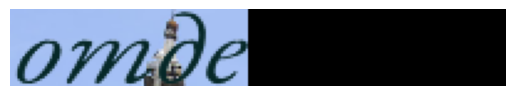

In [14]:
image, text = next(recognition_image_generators[1])
print('Это изображение содержит текст:', text)
plt.imshow(image)
plt.axis('off')
plt.show()

In [15]:
recognition_batch_size = 8
recognizer_basepath = os.path.join(data_dir, f'recognizer_{datetime.datetime.now().isoformat()}')

recognition_train_generator, recognition_val_generator, recognition_test_generator = [
    recognizer.get_batch_generator(
        image_generator=image_generator,
        batch_size=recognition_batch_size,
        lowercase=True
    ) for image_generator in recognition_image_generators
]

In [16]:
# Рассчитываем количество шагов на эпоху для распознавателя
train_steps_recognizer = math.ceil(len(train_words) / recognition_batch_size)
val_steps_recognizer = math.ceil(len(val_words) / recognition_batch_size)

# Обучение распознавателя
recognizer.training_model.fit(
    recognition_train_generator,
    epochs=1,
    steps_per_epoch=train_steps_recognizer,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(restore_best_weights=True, patience=10),
        tf.keras.callbacks.CSVLogger(f'{recognizer_basepath}.csv', append=True),
        tf.keras.callbacks.ModelCheckpoint(filepath=f'{recognizer_basepath}.h5')
    ],
    validation_data=recognition_val_generator,
    validation_steps=val_steps_recognizer,
    workers=0,
    batch_size=recognition_batch_size
)

2024-09-30 07:42:19.979014: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2024-09-30 07:42:21.627882: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


   3/4012 [..............................] - ETA: 21:13 - loss: 143.5684 

2024-09-30 07:42:24.129474: W tensorflow/core/framework/op_kernel.cc:1768] UNKNOWN: RuntimeError: generator raised StopIteration
Traceback (most recent call last):

  File "/usr/local/lib/python3.8/dist-packages/keras_ocr/data_generation.py", line 700, in get_image_generator
    text_image, lines = draw_text_image(

  File "/usr/local/lib/python3.8/dist-packages/keras_ocr/data_generation.py", line 387, in draw_text_image
    character_font_pairs = [

  File "/usr/local/lib/python3.8/dist-packages/keras_ocr/data_generation.py", line 390, in <listcomp>
    next(

StopIteration


The above exception was the direct cause of the following exception:


Traceback (most recent call last):

  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/ops/script_ops.py", line 271, in __call__
    ret = func(*args)

  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/usr/local/lib/python3.8/di

UnknownError: Graph execution error:

2 root error(s) found.
  (0) UNKNOWN:  RuntimeError: generator raised StopIteration
Traceback (most recent call last):

  File "/usr/local/lib/python3.8/dist-packages/keras_ocr/data_generation.py", line 700, in get_image_generator
    text_image, lines = draw_text_image(

  File "/usr/local/lib/python3.8/dist-packages/keras_ocr/data_generation.py", line 387, in draw_text_image
    character_font_pairs = [

  File "/usr/local/lib/python3.8/dist-packages/keras_ocr/data_generation.py", line 390, in <listcomp>
    next(

StopIteration


The above exception was the direct cause of the following exception:


Traceback (most recent call last):

  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/ops/script_ops.py", line 271, in __call__
    ret = func(*args)

  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/dataset_ops.py", line 1035, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/usr/local/lib/python3.8/dist-packages/keras/engine/data_adapter.py", line 903, in wrapped_generator
    for data in generator_fn():

  File "/usr/local/lib/python3.8/dist-packages/keras_ocr/recognition.py", line 433, in get_batch_generator
    batch = [sample for sample, _ in zip(image_generator, range(batch_size))]

  File "/usr/local/lib/python3.8/dist-packages/keras_ocr/recognition.py", line 433, in <listcomp>
    batch = [sample for sample, _ in zip(image_generator, range(batch_size))]

  File "/usr/local/lib/python3.8/dist-packages/keras_ocr/data_generation.py", line 293, in convert_image_generator_to_recognizer_input
    image, lines = next(image_generator)

RuntimeError: generator raised StopIteration


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
	 [[model_6/lambda_3/CTCLoss/_108]]
  (1) UNKNOWN:  RuntimeError: generator raised StopIteration
Traceback (most recent call last):

  File "/usr/local/lib/python3.8/dist-packages/keras_ocr/data_generation.py", line 700, in get_image_generator
    text_image, lines = draw_text_image(

  File "/usr/local/lib/python3.8/dist-packages/keras_ocr/data_generation.py", line 387, in draw_text_image
    character_font_pairs = [

  File "/usr/local/lib/python3.8/dist-packages/keras_ocr/data_generation.py", line 390, in <listcomp>
    next(

StopIteration


The above exception was the direct cause of the following exception:


Traceback (most recent call last):

  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/ops/script_ops.py", line 271, in __call__
    ret = func(*args)

  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/dataset_ops.py", line 1035, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/usr/local/lib/python3.8/dist-packages/keras/engine/data_adapter.py", line 903, in wrapped_generator
    for data in generator_fn():

  File "/usr/local/lib/python3.8/dist-packages/keras_ocr/recognition.py", line 433, in get_batch_generator
    batch = [sample for sample, _ in zip(image_generator, range(batch_size))]

  File "/usr/local/lib/python3.8/dist-packages/keras_ocr/recognition.py", line 433, in <listcomp>
    batch = [sample for sample, _ in zip(image_generator, range(batch_size))]

  File "/usr/local/lib/python3.8/dist-packages/keras_ocr/data_generation.py", line 293, in convert_image_generator_to_recognizer_input
    image, lines = next(image_generator)

RuntimeError: generator raised StopIteration


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_16957]